# SV with Particle filter (WIP) - free params and proposal, jointly optimized

In [1]:
import matplotlib.pyplot as plt
import torch

import ptvi

In [2]:
data_seed, algo_seed = 123, 123
params = dict(a=1., b=0., c=.95)
T = 200

In [3]:
model = ptvi.FilteredStochasticVolatilityModelFreeProposal(
    input_length=T, num_particles=8, resample=True)
model

Stochastic volatility model with parameters {a, b, c}:
	x_t = exp(a * z_t/2) ε_t        t=1,…,200
	z_t = b + c * z_{t-1} + ν_t,    t=2,…,200
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Filter with 8 particles; AR(1) proposal params {d, e, f}:
	z_t = d + e * z_{t-1} + f η_t,  t=2,…,200
	z_1 = d + f/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [4]:
torch.manual_seed(data_seed)
y, z_true = model.simulate(**params)

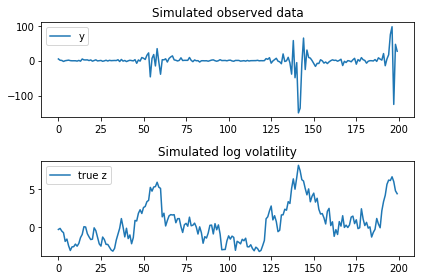

In [5]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [6]:
torch.manual_seed(algo_seed)
tracer = ptvi.PointEstimateTracer(model)
fit = ptvi.sgvb(model, y, tracer=tracer)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: Particle filtered stochastic volatility model
  - Using torch.float32 precision on cpu
  - Estimating elbo with M=1
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-2166.61
       1. smoothed elbo =-2104.16
       2. smoothed elbo =-3933.21
       4. smoothed elbo =-3435.54
       8. smoothed elbo =-4027.70
      16. smoothed elbo =-8395.22
      32. smoothed elbo =-35500.61
      64. smoothed elbo =-4080.51
     128. smoothed elbo =-2340.81
     256. smoothed elbo =-3497.44
     512. smoothed elbo =-4049.88
    1024. smoothed elbo =-1011.18
    2048. smoothed elbo = -674.75
Stopping heuristic criterion 

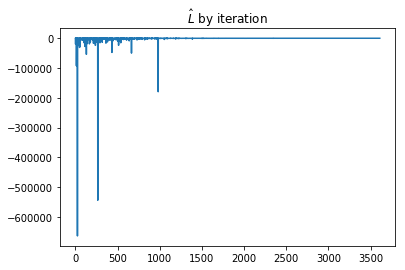

In [7]:
fit.plot_elbos()

In [8]:
fit.summary(true=params)

,mean,sd,true
a,1.504658,0.562281,1.00
b,0.074746,0.144767,0.00
c,0.911792,0.033945,0.95
d,0.301903,0.142358,NaN
e,0.897014,0.038115,NaN
f,1.680297,1.964937,NaN


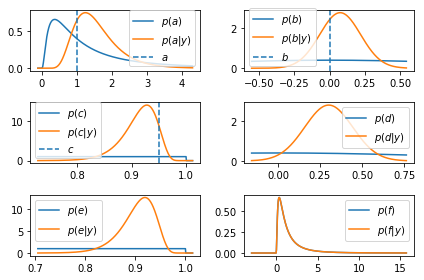

In [9]:
fit.plot_global_marginals(**params)

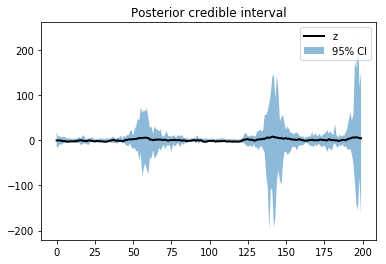

In [10]:
fit.plot_latent(N=50, true_z=z_true)

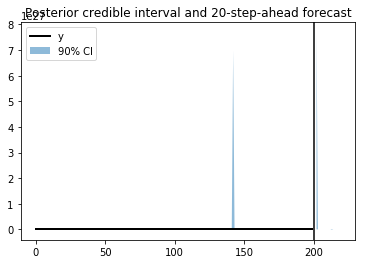

In [11]:
fit.plot_pred_ci(N=50, α=.1, true_y=y, fc_steps=20)